Load data from the data set into test, training and validation sets

In [1]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime

test = pd.read_csv("datasets/test.csv")
training = pd.read_csv("datasets/training.csv")
validation = pd.read_csv("datasets/validation.csv")

print("Dataset information: ")
print(f'Training data: {training.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information: 
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


Load tokenizer, model and create functions needed to process text

In [2]:
import string
import re
from transformers import DistilBertTokenizer, DistilBertModel
import contractions

# Load BERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')


def preprocess_text(text):
    # remove links
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # remove words like href, img, www, http, width, height, src
    text = re.sub(r"\S*(href|img|www|http|width|height|src)\S*", "", text)
    # remove contractions
    text = contractions.fix(text)
    # remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=False,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoded_input['input_ids'], encoded_input['attention_mask']

def extract_features(inputs, masks):
    print('Extract features' + ' - ' + str(datetime.now()))
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        pooled_output = outputs[0][:, 0, :]
    print('Finish extract features' + ' - ' + str(datetime.now()))
    return pooled_output.numpy()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform batch text preprocessing

In [3]:
# Preprocess training dataset
batch_size = 500
num_batches = len(training) // batch_size
training_features = []
for i in range(num_batches):
    print('Begin preprocess batch ' + str(i) + ' - ' + str(datetime.now()))
    # Get the current batch
    batch_data = training[i * batch_size : (i + 1) * batch_size]['text']
    batch_labels = training[i * batch_size : (i + 1) * batch_size]['label']

    # Preprocess the input text using DistilBERT for the current batch
    batch_inputs = []
    batch_masks = []
    print('Begin preprocess text in batch ' + str(i) + ' - ' + str(datetime.now()))
    for text in batch_data:
        input_ids, attention_mask = preprocess_text(text)
        batch_inputs.append(input_ids)
        batch_masks.append(attention_mask)

    batch_inputs = torch.cat(batch_inputs, dim=0)
    batch_masks = torch.cat(batch_masks, dim=0)

    pooled_output = extract_features(batch_inputs, batch_masks)
    training_features.append(pooled_output)
    print('Finish preprocess batch ' + str(i) + ' - ' + str(datetime.now()))
# obtain final features and labels
training_features = np.concatenate(training_features, axis=0)
training_labels = training['label'].values[:training_features.shape[0]]

# save the features and labels
np.save('models/training_features-3.npy', training_features)
np.save('models/training_labels-3.npy', training_labels)

Begin preprocess batch 0 - 2023-06-13 21:38:17.440726
Begin preprocess text in batch 0 - 2023-06-13 21:38:17.441725
Extract features - 2023-06-13 21:38:17.917765
Finish extract features - 2023-06-13 21:42:46.756882
Finish preprocess batch 0 - 2023-06-13 21:42:46.757882
Begin preprocess batch 1 - 2023-06-13 21:42:46.757882
Begin preprocess text in batch 1 - 2023-06-13 21:42:46.758882
Extract features - 2023-06-13 21:42:47.098889
Finish extract features - 2023-06-13 21:47:08.796492
Finish preprocess batch 1 - 2023-06-13 21:47:08.797451
Begin preprocess batch 2 - 2023-06-13 21:47:08.797451
Begin preprocess text in batch 2 - 2023-06-13 21:47:08.797451
Extract features - 2023-06-13 21:47:09.174459
Finish extract features - 2023-06-13 21:51:28.219486
Finish preprocess batch 2 - 2023-06-13 21:51:28.220487
Begin preprocess batch 3 - 2023-06-13 21:51:28.220487
Begin preprocess text in batch 3 - 2023-06-13 21:51:28.221486
Extract features - 2023-06-13 21:51:28.591487
Finish extract features - 20

In [4]:
# Oversample those classes that have less than 1000 samples to a total of half of the majority class using sklearn
from sklearn.utils import resample

# load the training features and labels
training_features = np.load('models/training_features-3.npy')
training_labels = np.load('models/training_labels-3.npy')

# compute the class distribution
class_distribution = np.bincount(training_labels)
print('Class distribution before oversampling: ', class_distribution)

# oversample the minority classes; if the class is not a minority class, then do not oversample it and keep it as it is
oversampled_features = []
oversampled_labels = []

majority_class_count = np.max(class_distribution)

for label in np.unique(training_labels):
    if class_distribution[label] < majority_class_count // 2:
        # oversample the minority class
        class_indices = np.where(training_labels == label)[0]
        oversampled_class_indices = resample(class_indices, replace=True, n_samples=majority_class_count // 2, random_state=0)

        oversampled_features.append(training_features[oversampled_class_indices])
        oversampled_labels.append(training_labels[oversampled_class_indices])
    else:
        # keep the majority class as it is
        majority_features = training_features[training_labels == label]
        majority_labels = training_labels[training_labels == label]

        # append the majority class to the list of oversampled features and labels
        oversampled_features.append(majority_features)
        oversampled_labels.append(majority_labels)

# obtain final features and labels
oversampled_features = np.concatenate(oversampled_features, axis=0)
oversampled_labels = np.concatenate(oversampled_labels, axis=0)

# save the features and labels
np.save('models/training_features-3-over.npy', oversampled_features)
np.save('models/training_labels-3-over.npy', oversampled_labels)

Class distribution before oversampling:  [4666 5362 1304 2159 1937  572]


Choose a suitable subset of the training data to find the best parameters for the SVM model

Class distribution of the entire training set:  [4666 5362 2681 2681 2681 2681]
Class distribution of the subset:  [1388 1641  794  750  829  823]


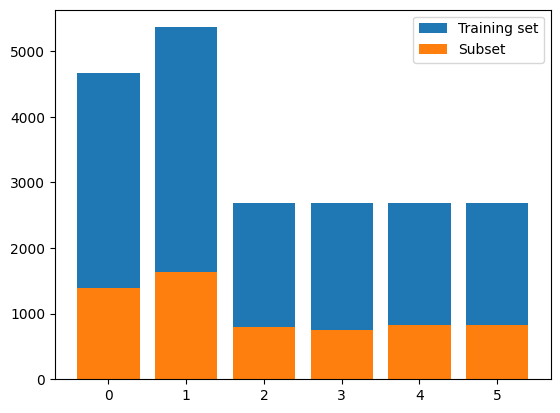

In [5]:
from sklearn.svm import SVC

# load the training features and labels
training_features = np.load('models/training_features-3-over.npy')
training_labels = np.load('models/training_labels-3-over.npy')

subset_size = 0.3
# split the training data into a subset and the remaining data
subset_indices = np.random.choice(len(training_features), int(subset_size * len(training_features)), replace=False)
subset_features = training_features[subset_indices]

# compute the class distribution of the subset
subset_labels = training_labels[subset_indices]
subset_class_distribution = np.bincount(subset_labels)

# compute the class distribution of the entire training set
training_class_distribution = np.bincount(training_labels)

# compare the class distributions
print('Class distribution of the entire training set: ', training_class_distribution)
print('Class distribution of the subset: ', subset_class_distribution)

# visualize plots of the class distributions
import matplotlib.pyplot as plt
plt.bar(np.arange(len(training_class_distribution)), training_class_distribution, label='Training set')
plt.bar(np.arange(len(subset_class_distribution)), subset_class_distribution, label='Subset')
plt.legend()
plt.show()


Perform grid search to find the best parameters for the SVM model

In [6]:
# SVM classification
parameters = {
    'C': [ 1, 50, 75, 90],
    'gamma': [1, 0.01, 0.001 , 'scale'],
    'kernel': ['rbf']
}
# Construct the final SVM
final_svm_classifier = SVC(class_weight='balanced')
# Perform grid search to find the best parameters
from sklearn.model_selection import GridSearchCV
print('Begin grid search' + ' - ' + str(datetime.now()))
grid_search = GridSearchCV(final_svm_classifier, parameters, cv=5)
print('Training SVM to find the best hyperparameters' + ' - ' + str(datetime.now()))
grid_search.fit(subset_features, subset_labels)
print('Finished looking for best hyperparameters' + ' - ' + str(datetime.now()))
print('Best hyperparameters: ', grid_search.best_params_)


Begin grid search - 2023-06-14 00:00:18.106661
Training SVM to find the best hyperparameters - 2023-06-14 00:00:18.107655
Finished looking for best hyperparameters - 2023-06-14 00:26:21.913114
Best hyperparameters:  {'C': 75, 'gamma': 0.01, 'kernel': 'rbf'}


Train the final SVM model with the best parameters

In [7]:
import joblib
# Use the best model for prediction
final_svm_classifier = grid_search.best_estimator_
# use the already existing model
print('Begin training final SVM model' + ' - ' + str(datetime.now()))
final_svm_classifier.fit(training_features, training_labels)
print('Finished training final SVM model' + ' - ' + str(datetime.now()))

Begin training final SVM model - 2023-06-14 00:26:21.921409
Finished training final SVM model - 2023-06-14 00:30:04.001030


Save the generated model for later use

In [8]:
# Save generated SVM model
import joblib
joblib.dump(final_svm_classifier, 'models/model-7-over.pkl')

['models/model-7-over.pkl']

Process test data

In [9]:
test_labels = []
test_features = []
# Extract features for test dataset
test_batch_size = 200
num_batches = len(test) // test_batch_size

for i in range(num_batches):
    print('Begin processing for test batch ' + str(i) + ' - ' + str(datetime.now()))
    test_batch_data = test[i * test_batch_size : (i + 1) * test_batch_size]['text']
    test_batch_labels = test[i * test_batch_size : (i + 1) * test_batch_size]['label']
    test_labels.extend(test_batch_labels)
    test_batch_inputs = []
    test_batch_masks = []
    for text in test_batch_data:
        input_ids, attention_mask = preprocess_text(text)
        test_batch_inputs.append(input_ids)
        test_batch_masks.append(attention_mask)
    test_batch_inputs = torch.cat(test_batch_inputs, dim=0)
    test_batch_masks = torch.cat(test_batch_masks, dim=0)
    print(i)
    pooled_output = extract_features(test_batch_inputs, test_batch_masks)
    test_features.append(pooled_output)
    print('End processing for test batch ' + str(i) + ' - ' + str(datetime.now()))

test_labels = torch.tensor(test_labels)
all_test_features = np.concatenate(test_features, axis=0)

# save the extracted test features and test labels for later use
np.save('models/test_features-3.npy', all_test_features)
np.save('models/test_labels-3.npy', test_labels)

Begin processing for test batch 0 - 2023-06-14 00:30:04.091654
0
Extract features - 2023-06-14 00:30:04.244649
Finish extract features - 2023-06-14 00:31:48.648705
End processing for test batch 0 - 2023-06-14 00:31:48.686704
Begin processing for test batch 1 - 2023-06-14 00:31:48.686704
1
Extract features - 2023-06-14 00:31:48.826702
Finish extract features - 2023-06-14 00:33:36.535275
End processing for test batch 1 - 2023-06-14 00:33:36.535275
Begin processing for test batch 2 - 2023-06-14 00:33:36.535275
2
Extract features - 2023-06-14 00:33:36.705311
Finish extract features - 2023-06-14 00:35:19.785276
End processing for test batch 2 - 2023-06-14 00:35:19.786275
Begin processing for test batch 3 - 2023-06-14 00:35:19.786275
3
Extract features - 2023-06-14 00:35:19.963282
Finish extract features - 2023-06-14 00:37:15.829324
End processing for test batch 3 - 2023-06-14 00:37:15.830323
Begin processing for test batch 4 - 2023-06-14 00:37:15.830323
4
Extract features - 2023-06-14 00:37

In [10]:
# Oversample those classes that have less than half samples to a total of half of the majority class using sklearn
from sklearn.utils import resample

# load the training features and labels
test_features = np.load('models/test_features-3.npy')
test_labels = np.load('models/test_labels-3.npy')

# compute the class distribution
class_distribution = np.bincount(test_labels)
print('Class distribution before oversampling: ', class_distribution)

# oversample the minority classes; if the class is not a minority class, then do not oversample it and keep it as it is
oversampled_features = []
oversampled_labels = []

majority_class_count = np.max(class_distribution)

for label in np.unique(training_labels):
    if class_distribution[label] < majority_class_count // 2:
        # oversample the minority class
        class_indices = np.where(training_labels == label)[0]
        oversampled_class_indices = resample(class_indices, replace=True, n_samples=majority_class_count // 2, random_state=0)

        oversampled_features.append(training_features[oversampled_class_indices])
        oversampled_labels.append(training_labels[oversampled_class_indices])
    else:
        # keep the majority class as it is
        majority_features = test_features[test_labels == label]
        majority_labels = test_labels[test_labels == label]

        # append the majority class to the list of oversampled features and labels
        oversampled_features.append(majority_features)
        oversampled_labels.append(majority_labels)

# obtain final features and labels
oversampled_features = np.concatenate(oversampled_features, axis=0)
oversampled_labels = np.concatenate(oversampled_labels, axis=0)

# save the features and labels
np.save('models/test_features-3-over.npy', oversampled_features)
np.save('models/test_labels-3-over.npy', oversampled_labels)

Class distribution before oversampling:  [581 695 159 275 224  66]


Predict for the test set

In [11]:
from sklearn.metrics import classification_report
# load the test features and labels
all_test_features = np.load('models/test_features-3-over.npy')
test_labels = np.load('models/test_labels-3-over.npy')
print('Begin prediction' + ' - ' + str(datetime.now()))
loaded_svm_classifier = joblib.load('models/model-7-over.pkl')
predictions = loaded_svm_classifier.predict(all_test_features)
print('Finish prediction' + ' - ' + str(datetime.now()))
report = classification_report(test_labels, predictions)
print(report)

Begin prediction - 2023-06-14 00:49:07.220895
Finish prediction - 2023-06-14 00:49:44.867409
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       581
           1       0.86      0.75      0.80       695
           2       0.85      1.00      0.92       347
           3       0.85      1.00      0.92       347
           4       0.89      0.99      0.94       347
           5       0.96      1.00      0.98       347

    accuracy                           0.87      2664
   macro avg       0.87      0.91      0.89      2664
weighted avg       0.87      0.87      0.87      2664



In [40]:
test_case1 = 'i do feel completely isolated'
loaded_svm_classifier = joblib.load('models/model-7-over.pkl')
input_ids, attention_mask = preprocess_text(test_case1)
test_features = extract_features(input_ids, attention_mask)
prediction = loaded_svm_classifier.predict(test_features)
print("Prediction: ", prediction)

Extract features - 2023-06-14 01:42:13.747668
Finish extract features - 2023-06-14 01:42:14.569670
Prediction:  [0]


In [41]:
# predict for the training set
all_training_features = np.load('models/training_features-3-over.npy')
training_labels = np.load('models/training_labels-3-over.npy')
print('Begin prediction' + ' - ' + str(datetime.now()))
loaded_svm_classifier = joblib.load('models/model-7-over.pkl')
predictions = loaded_svm_classifier.predict(all_training_features)
print('Finish prediction' + ' - ' + str(datetime.now()))
report = classification_report(training_labels, predictions)
print(report)


Begin prediction - 2023-06-14 02:23:07.805972
Finish prediction - 2023-06-14 02:28:40.461785
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4666
           1       1.00      0.99      0.99      5362
           2       0.99      1.00      1.00      2681
           3       1.00      1.00      1.00      2681
           4       1.00      1.00      1.00      2681
           5       1.00      1.00      1.00      2681

    accuracy                           0.99     20752
   macro avg       0.99      1.00      1.00     20752
weighted avg       0.99      0.99      0.99     20752

